# Recurrent Neural Network

## Intro

In this notebook we are going to predict Google's open stock price over January 2017, using 5 years of historic data on the open stock prices of Google, Apple and Microsoft (2012-2016). All that using a stacked Long-Short Term Memory model.

## Part 1 - Data Preprocessing

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

### Importing the training and test set

Import the stock price train data of Google

In [2]:
# import the Google train dataset and use just the open values
train_google_og = pd.read_csv('data\Google_Stock_Price_Train.csv')
train_google = train_google_og.loc[:, 'Open'].values
print('Train set - Google', train_google)

# import the Google test dataset and use just the open values
test_google_og = pd.read_csv('data\Google_Stock_Price_Test.csv')
test_google = test_google_og.loc[:, 'Open'].values
print('Test set - Google', test_google)

Train set - Google [325.25 331.27 329.83 ... 793.7  783.33 782.75]
Test set - Google [778.81 788.36 786.08 795.26 806.4  807.86 805.   807.14 807.48 807.08
 805.81 805.12 806.91 807.25 822.3  829.62 837.81 834.71 814.66 796.86]


In [3]:
# get the shape of the sets
print('Train set shape: ', train_google.shape)
print('Test set shape: ', test_google.shape)

Train set shape:  (1258,)
Test set shape:  (20,)


In [4]:
# get the most recent date to cut the apple and microsoft file accordingly
train_google_og.Date.iloc[-1]

'12/30/2016'

In [5]:
# import the Microsoft dataset and again just use the open values
msft_og = pd.read_csv('data\MSFT.csv')
msft = msft_og.loc[:, 'Open'].values
train_msft = msft[0:1258]
test_msft = msft[1258:]


# import the Apple dataset and again just use the open values
aapl_og = pd.read_csv('data\AAPL.csv')
aapl = aapl_og.loc[:, 'Open'].values
train_aapl = aapl[0:1258]
test_aapl = aapl[1258:]

In [6]:
# sanity checks
print('MSFT stock on the last date of the training set: ', '\n')
print('shape of train set: ', train_msft.shape, '\n')
print(msft_og.loc[1257, ['Date', 'Open']], '\n')
print(msft[1257])
print(train_msft[-1])
print('\n')

print('MSFT stock on the first date of the test set: ', '\n')
print('shape of test set: ', test_msft.shape, '\n')
print(msft_og.loc[1258, ['Date', 'Open']], '\n')
print(msft[1258])
print(test_msft[0])
print('\n')

print('AAPL stock on the last date of the training set: ', '\n')
print('shape of train set: ', train_aapl.shape, '\n')
print(aapl_og.loc[1257, ['Date', 'Open']], '\n')
print(aapl[1257])
print(train_aapl[-1])
print('\n')

print('AAPL stock on the first date of the test set: ', '\n')
print('shape of test set: ', test_aapl.shape, '\n')
print(aapl_og.loc[1258, ['Date', 'Open']], '\n')
print(aapl[1258])
print(test_aapl[0])
print('\n')

print('Google stock on the last date of the training set: ', '\n')
print('shape of train set: ', train_google.shape, '\n')
print(train_google_og.loc[1257, ['Date', 'Open']], '\n')
print(train_google[1257])
print(train_google[-1])
print('\n')

print('Google stock on the first date of the test set: ', '\n')
print('shape of test set: ', test_google.shape, '\n')
print(test_google_og.loc[0, ['Date', 'Open']], '\n')
print(test_google[0])

MSFT stock on the last date of the training set:  

shape of train set:  (1258,) 

Date    2016-12-30
Open     62.959999
Name: 1257, dtype: object 

62.959999
62.959999


MSFT stock on the first date of the test set:  

shape of test set:  (20,) 

Date    2017-01-03
Open     62.790001
Name: 1258, dtype: object 

62.790001
62.790001


AAPL stock on the last date of the training set:  

shape of train set:  (1258,) 

Date    2016-12-30
Open       29.1625
Name: 1257, dtype: object 

29.1625
29.1625


AAPL stock on the first date of the test set:  

shape of test set:  (20,) 

Date    2017-01-03
Open     28.950001
Name: 1258, dtype: object 

28.950001
28.950001


Google stock on the last date of the training set:  

shape of train set:  (1258,) 

Date    12/30/2016
Open        782.75
Name: 1257, dtype: object 

782.75
782.75


Google stock on the first date of the test set:  

shape of test set:  (20,) 

Date    1/3/2017
Open      778.81
Name: 0, dtype: object 

778.81


### Visualizing the test data

Text(0.0, 1.0, 'Microsoft')

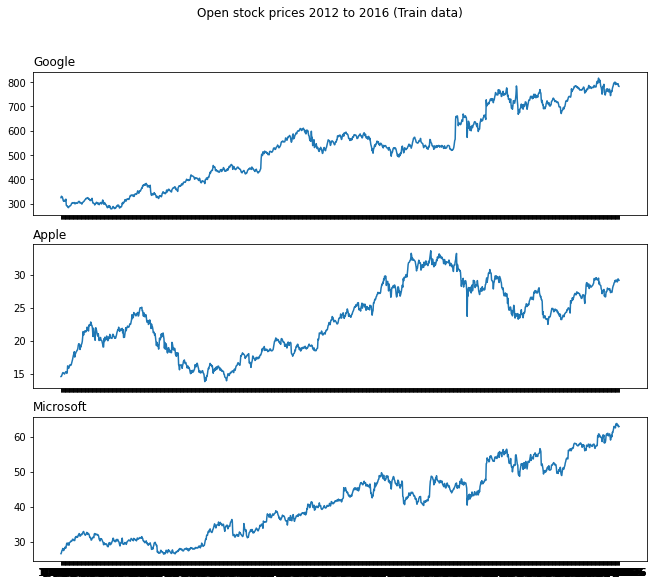

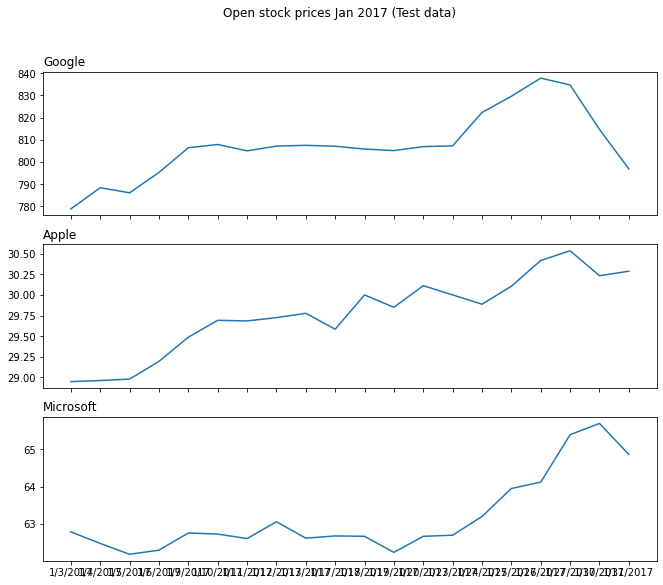

In [7]:
fig, ax = plt.subplots(3, sharex=True, figsize=[11,9])
fig.suptitle('Open stock prices 2012 to 2016 (Train data)')
ax[0].plot(train_google_og.Date, train_google)
ax[0].set_title('Google', loc = 'left')
ax[1].plot(train_google_og.Date, train_aapl)
ax[1].set_title('Apple', loc = 'left')
ax[2].plot(train_google_og.Date, train_msft)
ax[2].set_title('Microsoft', loc = 'left')


fig, ax = plt.subplots(3, sharex=True, figsize=[11,9])
fig.suptitle('Open stock prices Jan 2017 (Test data)')
ax[0].plot(test_google_og.Date, test_google)
ax[0].set_title('Google', loc = 'left')
ax[1].plot(test_google_og.Date, test_aapl)
ax[1].set_title('Apple', loc = 'left')
ax[2].plot(test_google_og.Date, test_msft)
ax[2].set_title('Microsoft', loc = 'left')

### Feature Scaling

In [8]:
# recommended to use normalization instead of standardization
from sklearn.preprocessing import MinMaxScaler
sc_google = MinMaxScaler()
sc_msft = MinMaxScaler()
sc_aapl = MinMaxScaler()

# reshape to 2d array
train_google = train_google.reshape(-1, 1)
train_msft = train_msft.reshape(-1, 1)
train_aapl = train_aapl.reshape(-1, 1)
test_google = test_google.reshape(-1, 1)
test_msft = test_msft.reshape(-1, 1)
test_aapl = test_aapl.reshape(-1, 1)

# normalize (only transform the test set to avoid info leakage)
train_google_sc = sc_google.fit_transform(train_google)
test_google_sc = sc_google.transform(test_google)

train_msft_sc = sc_msft.fit_transform(train_msft)
test_msft_sc = sc_msft.transform(test_msft)

train_aapl_sc = sc_aapl.fit_transform(train_aapl)
test_aapl_sc = sc_aapl.transform(test_aapl)

# also define y_test
y_test = test_google_sc 

### Creating the 3d data structure with 60 timesteps and 1 output

In [9]:
# initialize empty lists
X_train_google = []
X_train_msft = []
X_train_aapl = []
y_train = []

# create y output values - to each one of them correspond the 60 previous timestamps from each stock
for timestamp in range(60, train_google_sc.shape[0]):
    y_train.append(train_google_sc[timestamp, 0])
    X_train_google.append(train_google_sc[timestamp-60: timestamp, 0])
    X_train_msft.append(train_msft_sc[timestamp-60: timestamp, 0])
    X_train_aapl.append(train_aapl_sc[timestamp-60: timestamp, 0])

# convert lists to arrays 
X_train_google = np.array(X_train_google)
X_train_msft = np.array(X_train_msft)
X_train_aapl = np.array(X_train_aapl)
y_train = np.array(y_train)

# stack along the last axis to create a 3-dimensional list
X_train = np.stack((X_train_google, X_train_msft, X_train_aapl), axis=-1)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (1198, 60, 3)
y_train shape:  (1198,)


In [10]:
# sanity check
print('Train - Google')
display(pd.DataFrame(X_train[:,:,0]))

print('Train - MSFT')
display(pd.DataFrame(X_train[:,:,1]))

print('Train - AAPL')
display(pd.DataFrame(X_train[:,:,2]))

Train - Google


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.085814,0.097012,0.094334,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,...,0.052143,0.056124,0.058189,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977
1,0.097012,0.094334,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,...,0.056124,0.058189,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279
2,0.094334,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,0.074745,...,0.058189,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279,0.084716
3,0.091562,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,0.074745,0.027978,...,0.065407,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279,0.084716,0.074541
4,0.079842,0.064328,0.058542,0.065686,0.061091,0.066393,0.061426,0.074745,0.027978,0.023793,...,0.068830,0.072438,0.079935,0.078466,0.080345,0.084977,0.086279,0.084716,0.074541,0.078838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,0.934445,0.924939,0.921069,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,...,0.931766,0.941141,0.957623,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759
1194,0.924939,0.921069,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,...,0.941141,0.957623,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043
1195,0.921069,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,...,0.957623,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633
1196,0.924381,0.930482,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,...,0.964134,0.964023,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251


Train - MSFT


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.004538,0.011746,0.026695,0.030699,0.044581,0.041377,0.028030,0.039776,0.041377,0.053924,...,0.171116,0.174319,0.164442,0.152696,0.148959,0.144955,0.152696,0.155099,0.167379,0.163908
1,0.011746,0.026695,0.030699,0.044581,0.041377,0.028030,0.039776,0.041377,0.053924,0.051522,...,0.174319,0.164442,0.152696,0.148959,0.144955,0.152696,0.155099,0.167379,0.163908,0.151628
2,0.026695,0.030699,0.044581,0.041377,0.028030,0.039776,0.041377,0.053924,0.051522,0.047517,...,0.164442,0.152696,0.148959,0.144955,0.152696,0.155099,0.167379,0.163908,0.151628,0.160705
3,0.030699,0.044581,0.041377,0.028030,0.039776,0.041377,0.053924,0.051522,0.047517,0.065136,...,0.152696,0.148959,0.144955,0.152696,0.155099,0.167379,0.163908,0.151628,0.160705,0.155900
4,0.044581,0.041377,0.028030,0.039776,0.041377,0.053924,0.051522,0.047517,0.065136,0.084624,...,0.148959,0.144955,0.152696,0.155099,0.167379,0.163908,0.151628,0.160705,0.155900,0.154298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,0.839028,0.832621,0.828350,0.824613,0.825147,0.837160,0.840096,0.841698,0.841164,0.820342,...,0.928991,0.946076,0.964229,0.977576,0.969568,0.976241,0.965830,0.995996,0.989055,1.000000
1194,0.832621,0.828350,0.824613,0.825147,0.837160,0.840096,0.841698,0.841164,0.820342,0.809397,...,0.946076,0.964229,0.977576,0.969568,0.976241,0.965830,0.995996,0.989055,1.000000,0.989589
1195,0.828350,0.824613,0.825147,0.837160,0.840096,0.841698,0.841164,0.820342,0.809397,0.820609,...,0.964229,0.977576,0.969568,0.976241,0.965830,0.995996,0.989055,1.000000,0.989589,0.983182
1196,0.824613,0.825147,0.837160,0.840096,0.841698,0.841164,0.820342,0.809397,0.820609,0.827016,...,0.977576,0.969568,0.976241,0.965830,0.995996,0.989055,1.000000,0.989589,0.983182,0.988254


Train - AAPL


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.038735,0.039819,0.048766,0.057479,0.067836,0.068577,0.062738,0.062015,0.057352,0.065486,...,0.382539,0.355626,0.380298,0.382359,0.388197,0.379232,0.384130,0.382865,0.394415,0.416466
1,0.039819,0.048766,0.057479,0.067836,0.068577,0.062738,0.062015,0.057352,0.065486,0.070474,...,0.355626,0.380298,0.382359,0.388197,0.379232,0.384130,0.382865,0.394415,0.416466,0.406344
2,0.048766,0.057479,0.067836,0.068577,0.062738,0.062015,0.057352,0.065486,0.070474,0.076240,...,0.380298,0.382359,0.388197,0.379232,0.384130,0.382865,0.394415,0.416466,0.406344,0.399096
3,0.057479,0.067836,0.068577,0.062738,0.062015,0.057352,0.065486,0.070474,0.076240,0.071432,...,0.382359,0.388197,0.379232,0.384130,0.382865,0.394415,0.416466,0.406344,0.399096,0.386552
4,0.067836,0.068577,0.062738,0.062015,0.057352,0.065486,0.070474,0.076240,0.071432,0.062720,...,0.388197,0.379232,0.384130,0.382865,0.394415,0.416466,0.406344,0.399096,0.386552,0.432589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,0.730502,0.721645,0.724808,0.729236,0.733538,0.737334,0.745052,0.754035,0.787944,0.783516,...,0.719747,0.732146,0.739105,0.754288,0.758590,0.772381,0.763904,0.775797,0.776557,0.770863
1194,0.721645,0.724808,0.729236,0.733538,0.737334,0.745052,0.754035,0.787944,0.783516,0.776430,...,0.732146,0.739105,0.754288,0.758590,0.772381,0.763904,0.775797,0.776557,0.770863,0.761247
1195,0.724808,0.729236,0.733538,0.737334,0.745052,0.754035,0.787944,0.783516,0.776430,0.790221,...,0.739105,0.754288,0.758590,0.772381,0.763904,0.775797,0.776557,0.770863,0.761247,0.773014
1196,0.729236,0.733538,0.737334,0.745052,0.754035,0.787944,0.783516,0.776430,0.790221,0.783262,...,0.754288,0.758590,0.772381,0.763904,0.775797,0.776557,0.770863,0.761247,0.773014,0.785666


In [11]:
# sanity check
print('Train - Output(Google)')
display(pd.DataFrame(y_train))

Train - Output(Google)


,0
0,0.086279
1,0.084716
2,0.074541
3,0.078838
4,0.072383
...,...
1193,0.952043
1194,0.951633
1195,0.957251
1196,0.937960


## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [13]:
rnn = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [14]:
rnn.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
# In the first layer we need to include the input shape. 
# The input shape is in 3d but we only need to input the 2 dimensions: timesteps and indicators. 
# The first dimension (number of observations) is automatically taken into account later.

In [15]:
rnn.add(Dropout(rate=0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [16]:
rnn.add(LSTM(units = 50, return_sequences=True))
rnn.add(Dropout(rate=0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [17]:
rnn.add(LSTM(units = 50, return_sequences=True))
rnn.add(Dropout(rate=0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [18]:
rnn.add(LSTM(units = 50, return_sequences=False))
rnn.add(Dropout(rate=0.2))

### Adding the output layer

In [19]:
rnn.add(Dense(units=1))

In [20]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10800     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

### Compiling the RNN

In [21]:
#RMSProp is recommended by Keras as the optimizer for RNNs. We'll use Adam anyway.
#Also use MSE instead of RMSE as it is more appropriate for stock price loss
rnn.compile(optimizer='Adam', loss='mean_squared_error')

### Fitting the RNN to the Training set

In [22]:
# Also specify a batch size here.
history = rnn.fit(x = X_train, y = y_train, batch_size=32, epochs=200)

Epoch 1/200
38/38 [==============================] - 5s 33ms/step - loss: 0.0374
Epoch 2/200
38/38 [==============================] - 1s 36ms/step - loss: 0.0073
Epoch 3/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0061
Epoch 4/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0051
Epoch 5/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0052
Epoch 6/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0048
Epoch 7/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0049
Epoch 8/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0045
Epoch 9/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0051
Epoch 10/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0043
Epoch 11/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0040
Epoch 12/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0045
Epoch 13/200
38/38 [=====

38/38 [==============================] - 1s 35ms/step - loss: 0.0016
Epoch 102/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0015
Epoch 103/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0015
Epoch 104/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0016
Epoch 105/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0017
Epoch 106/200
38/38 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 107/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0014
Epoch 108/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0013
Epoch 109/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0013
Epoch 110/200
38/38 [==============================] - 1s 36ms/step - loss: 0.0014
Epoch 111/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0014
Epoch 112/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0016
Epoch 113/200
38/3

38/38 [==============================] - 1s 35ms/step - loss: 9.1791e-04
Epoch 200/200
38/38 [==============================] - 1s 35ms/step - loss: 0.0010


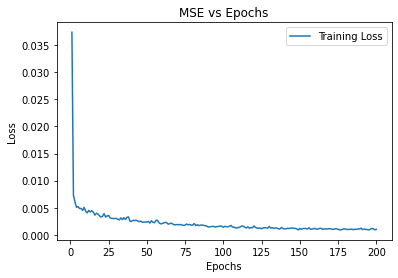

In [23]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MSE vs Epochs')

plt.show()

MSE in the training set seems to converge to 9e-04 (normalized values).

## Part 3 - Making the predictions and visualising the results

In [24]:
# for prediction we'll need values from both the train and the test set, as we'll have to look 60 days back. 
# concatenate the two arrays for each stock.

data_google_sc = np.concatenate((train_google_sc, test_google_sc))
data_msft_sc = np.concatenate((train_msft_sc, test_msft_sc))
data_aapl_sc = np.concatenate((train_aapl_sc, test_aapl_sc))

# initialize empty lists
X_test_google = []
X_test_msft = []
X_test_aapl = []

# store the index of where the test set begins
index_test = data_google_sc.shape[0] - test_google_sc.shape[0]

# create the data structure with the previous 60 observations to the current timestamp
for timestamp in range(index_test, data_google_sc.shape[0]):
    X_test_google.append(data_google_sc[timestamp-60: timestamp, 0])
    X_test_msft.append(data_msft_sc[timestamp-60: timestamp, 0])
    X_test_aapl.append(data_aapl_sc[timestamp-60: timestamp, 0])
    
# convert lists to arrays 
X_test_google = np.array(X_test_google)
X_test_msft = np.array(X_test_msft)
X_test_aapl = np.array(X_test_aapl)
y_test = np.array(y_test)

# stack along the last axis to create a 3-dimensional list
X_test = np.stack((X_test_google, X_test_msft, X_test_aapl), axis=-1)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape:  (20, 60, 3)
y_test shape:  (20, 1)


In [25]:
# sanity check
print('Test - Google')
display(pd.DataFrame(X_test[:,:,0]))

print('Test - MSFT')
display(pd.DataFrame(X_test[:,:,1]))

print('Test - AAPL')
display(pd.DataFrame(X_test[:,:,2]))

Test - Google


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.929905,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,...,0.969715,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881
1,0.931133,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,...,0.950778,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552
2,0.927506,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,...,0.962944,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318
3,0.944155,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,...,0.961232,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076
4,0.938760,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,...,0.954759,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153
5,0.934035,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,...,0.952043,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877
6,0.934835,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,...,0.951633,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593
7,0.931394,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,0.984504,...,0.957251,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593,0.978272
8,0.946369,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,0.984504,0.960544,...,0.937960,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593,0.978272,0.982253
9,0.965697,0.975110,0.959670,0.978086,1.000000,0.980765,0.970831,0.984504,0.960544,0.937142,...,0.936881,0.929552,0.947318,0.943076,0.960153,0.980877,0.983593,0.978272,0.982253,0.982886


Test - MSFT


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.837160,0.840096,0.841698,0.841164,0.820342,0.809397,0.820609,0.827016,0.831554,0.829952,...,0.976241,0.965830,0.995996,0.989055,1.000000,0.989589,0.983182,0.988254,0.973839,0.976508
1,0.840096,0.841698,0.841164,0.820342,0.809397,0.820609,0.827016,0.831554,0.829952,0.830753,...,0.965830,0.995996,0.989055,1.000000,0.989589,0.983182,0.988254,0.973839,0.976508,0.971970
2,0.841698,0.841164,0.820342,0.809397,0.820609,0.827016,0.831554,0.829952,0.830753,0.904965,...,0.995996,0.989055,1.000000,0.989589,0.983182,0.988254,0.973839,0.976508,0.971970,0.963695
3,0.841164,0.820342,0.809397,0.820609,0.827016,0.831554,0.829952,0.830753,0.904965,0.895889,...,0.989055,1.000000,0.989589,0.983182,0.988254,0.973839,0.976508,0.971970,0.963695,0.955953
4,0.820342,0.809397,0.820609,0.827016,0.831554,0.829952,0.830753,0.904965,0.895889,0.920181,...,1.000000,0.989589,0.983182,0.988254,0.973839,0.976508,0.971970,0.963695,0.955953,0.958889
5,0.809397,0.820609,0.827016,0.831554,0.829952,0.830753,0.904965,0.895889,0.920181,0.919114,...,0.989589,0.983182,0.988254,0.973839,0.976508,0.971970,0.963695,0.955953,0.958889,0.971169
6,0.820609,0.827016,0.831554,0.829952,0.830753,0.904965,0.895889,0.920181,0.919114,0.913775,...,0.983182,0.988254,0.973839,0.976508,0.971970,0.963695,0.955953,0.958889,0.971169,0.970368
7,0.827016,0.831554,0.829952,0.830753,0.904965,0.895889,0.920181,0.919114,0.913775,0.897758,...,0.988254,0.973839,0.976508,0.971970,0.963695,0.955953,0.958889,0.971169,0.970368,0.967165
8,0.831554,0.829952,0.830753,0.904965,0.895889,0.920181,0.919114,0.913775,0.897758,0.901762,...,0.973839,0.976508,0.971970,0.963695,0.955953,0.958889,0.971169,0.970368,0.967165,0.979178
9,0.829952,0.830753,0.904965,0.895889,0.920181,0.919114,0.913775,0.897758,0.901762,0.896690,...,0.976508,0.971970,0.963695,0.955953,0.958889,0.971169,0.970368,0.967165,0.979178,0.967432


Test - AAPL


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.737334,0.745052,0.754035,0.787944,0.783516,0.776430,0.790221,0.783262,0.794017,0.782250,...,0.772381,0.763904,0.775797,0.776557,0.770863,0.761247,0.773014,0.785666,0.772128,0.774659
1,0.745052,0.754035,0.787944,0.783516,0.776430,0.790221,0.783262,0.794017,0.782250,0.777316,...,0.763904,0.775797,0.776557,0.770863,0.761247,0.773014,0.785666,0.772128,0.774659,0.763904
2,0.754035,0.787944,0.783516,0.776430,0.790221,0.783262,0.794017,0.782250,0.777316,0.776683,...,0.775797,0.776557,0.770863,0.761247,0.773014,0.785666,0.772128,0.774659,0.763904,0.764537
3,0.787944,0.783516,0.776430,0.790221,0.783262,0.794017,0.782250,0.777316,0.776683,0.780352,...,0.776557,0.770863,0.761247,0.773014,0.785666,0.772128,0.774659,0.763904,0.764537,0.765422
4,0.783516,0.776430,0.790221,0.783262,0.794017,0.782250,0.777316,0.776683,0.780352,0.791107,...,0.770863,0.761247,0.773014,0.785666,0.772128,0.774659,0.763904,0.764537,0.765422,0.776304
5,0.776430,0.790221,0.783262,0.794017,0.782250,0.777316,0.776683,0.780352,0.791107,0.745052,...,0.761247,0.773014,0.785666,0.772128,0.774659,0.763904,0.764537,0.765422,0.776304,0.791107
6,0.790221,0.783262,0.794017,0.782250,0.777316,0.776683,0.780352,0.791107,0.745052,0.758717,...,0.773014,0.785666,0.772128,0.774659,0.763904,0.764537,0.765422,0.776304,0.791107,0.801482
7,0.783262,0.794017,0.782250,0.777316,0.776683,0.780352,0.791107,0.745052,0.758717,0.739485,...,0.785666,0.772128,0.774659,0.763904,0.764537,0.765422,0.776304,0.791107,0.801482,0.801102
8,0.794017,0.782250,0.777316,0.776683,0.780352,0.791107,0.745052,0.758717,0.739485,0.736701,...,0.772128,0.774659,0.763904,0.764537,0.765422,0.776304,0.791107,0.801482,0.801102,0.803127
9,0.782250,0.777316,0.776683,0.780352,0.791107,0.745052,0.758717,0.739485,0.736701,0.734297,...,0.774659,0.763904,0.764537,0.765422,0.776304,0.791107,0.801482,0.801102,0.803127,0.805784


In [26]:
# sanity check
pd.DataFrame(y_test)

,0
0,0.929552
1,0.947318
2,0.943076
3,0.960153
4,0.980877
5,0.983593
6,0.978272
7,0.982253
8,0.982886
9,0.982142


### Getting the predicted stock price of 2017

In [27]:
y_pred = rnn.predict(X_test, batch_size=32)

In [28]:
# inverse the normalization
y_pred = sc_google.inverse_transform(y_pred)
y_pred

array([[798.133  ],
       [796.67365],
       [798.6156 ],
       [798.6345 ],
       [800.83453],
       [805.25287],
       [807.36365],
       [807.1478 ],
       [808.0325 ],
       [808.8279 ],
       [808.91205],
       [808.7698 ],
       [808.39923],
       [808.9173 ],
       [809.31335],
       [812.80255],
       [816.2158 ],
       [818.9017 ],
       [819.94946],
       [817.0219 ]], dtype=float32)

### Visualising the results

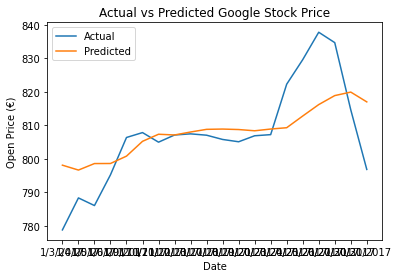

In [29]:
plt.plot(test_google_og.Date, test_google_og.Open, label='Actual')
plt.plot(test_google_og.Date, y_pred[:, 0], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Open Price (€)')
plt.legend()
plt.title('Actual vs Predicted Google Stock Price')

plt.show()

In [30]:
MSE = np.square(np.subtract(test_google_og.Open, y_pred[:, 0])).mean()
print('Mean Squared Error: ', MSE)

Mean Squared Error:  114.39279974809457


### Results Summary

Using Microsoft and Apple stock as additional features actually produced worse results than the model with Google's stock price as the only predictor (MSE = 114 vs 76), using same LSTM model hyperparameters and 200 epochs). The additional features seem to have convoluted the prediction which in this case is much smoother vs the single predictor model, and failed to capture the peak that occured late January.